# Principal Component Analysis on (Fashion) MNIST

In this project I studied the technique of Principal Component Anaysis on the (Fashion) MNIST dataset. Images get reduced into lower dimensions while preserving as much information about the image as possible.

In [1]:
import math
from time import time

import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import tensorflow as tf
from numpy.random import randint

### Auxiliary Functions

In [2]:
def plt_img(vector, title=None, pos=None, img_shape=(28, 28, 1)):
    """Auxiliary function for plotting images.

    Args:
        vector (np.array): Array with shape (d,).
        title (str, optional): Title to be displayed above image. Defaults to None.
        color (str, optional): Color of title. Defaults to "black".
        pos (tuple, optional): (n_row, n_col, number) if more than one image should be plotted. Defaults to None.
        img_shape (tuple, optional): Shape of image. Defaults to (28, 28, 1).
    """
    if pos is not None:
        plt.subplot(pos[0], pos[1], pos[2])
    if title is not None:
        plt.title(title)
    plt.imshow(vector.reshape(img_shape), cmap='gray_r')
    plt.axis('off')

## Load and Prepare Data

In [3]:
(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
classes = np.array([0,1,2,3,4,5,6,7,8,9]) #class label = indizes

In [4]:
## fashion-mnist
#(x, y), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
#classes = np.array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

In [5]:
# describe the original data
description = f'''Original data:
x.shape      = {x.shape}
y.shape      = {y.shape}
x_test.shape = {x_test.shape}
y_test.shape = {y_test.shape}
x.dtype      = {x.dtype}
Domain of x-data: [{np.min(x)}, {np.max(x)}]
y.dtype      = {y.dtype}
Domain of y-data: {set(np.unique(y))}'''
print(description)

Original data:
x.shape      = (60000, 28, 28)
y.shape      = (60000,)
x_test.shape = (10000, 28, 28)
y_test.shape = (10000,)
x.dtype      = uint8
Domain of x-data: [0, 255]
y.dtype      = uint8
Domain of y-data: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [6]:
# prepare the data
n, img_shape = x.shape[0], x.shape[1:]
d = img_shape[0]*img_shape[1]
n_test = x_test.shape[0]
x, x_test = x.reshape(n,d), x_test.reshape(n_test,d)
x, x_test = x/255.0, x_test/255.0
m = classes.shape[0]

In [7]:
description = f'''Prepared x-data:
x.shape      = {x.shape}
x_test.shape = {x_test.shape}
x.dtype      = {x.dtype}
Domain x-data: [{np.min(x)}, {np.max(x)}]'''
print(description)

prepared x-data:
x.shape      = (60000, 784)
x_test.shape = (10000, 784)
x.dtype      = float64
Domain x-data: [0.0, 1.0]


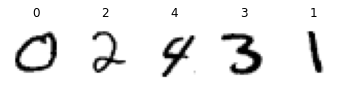

In [8]:
# sample and plot examples
n_row = 5
for k in range(n_row):
    j = randint(n)
    plt_img(x[j], title=f'{classes[y[j]]}', pos=(1,n_row,k+1))
plt.show()

## Full Principal Component Analysis

At first we do a full principal component analysis of the $x$ data, then plot the eigenvalues in descending order and finally visualize the first principal components. 

In [9]:
from sklearn.decomposition import PCA
#full pca
full_pca = PCA(n_components=d)
x_transformed = full_pca.fit_transform(x)  # data gets centered automatically
# principal components
v = full_pca.components_
# eigenvalues in descending order
lam = full_pca.explained_variance_

Check whether lam is really an ONB of eigenvectors and eigenvalues.

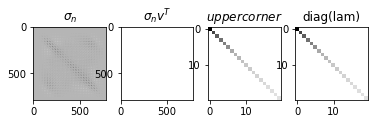

In [10]:
Sigma_n = np.cov(x.T)  # empirical covariance-matrix
diagonalisiert = np.dot(np.dot(v,Sigma_n),v.T)
plt.subplot(1,4,1)
plt.title('$\sigma_n$')
plt.imshow(Sigma_n,cmap='gray_r')
plt.subplot(1,4,2)
plt.title('$\sigma_n v^T$')
plt.imshow(diagonalisiert,cmap='gray_r')
plt.subplot(1,4,3)
plt.title('$upper corner$')
plt.imshow(diagonalisiert[:20,:20],cmap='gray_r')
plt.subplot(1,4,4)
plt.title('diag(lam)')
plt.imshow(np.diag(lam)[:20,:20],cmap='gray_r')
plt.show()

The first k=33 Principal components contain at least 75% of the total variance


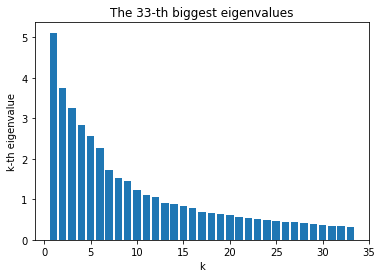

In [11]:
variance_ratio = full_pca.explained_variance_ratio_
frac_of_variance = np.cumsum(variance_ratio)
threshold = 0.75
# smallest k so that the first k principal components account for at least threshold of the total variance
k = np.where(frac_of_variance>=threshold)[0][0] 
print(f'The first k={k} Principal components contain at least {100*threshold:.0f}% of the total variance')

plt.figure(figsize=(6,4))
plt.title(f'The {k}-th biggest eigenvalues')
plt.bar(range(1,k+1),lam[:k])
plt.xlabel('k')
plt.ylabel('k-th eigenvalue')
plt.show()

The first principal components (PC) are now plotted as images. We also indicate the fraction of the total variance that is in this PC.

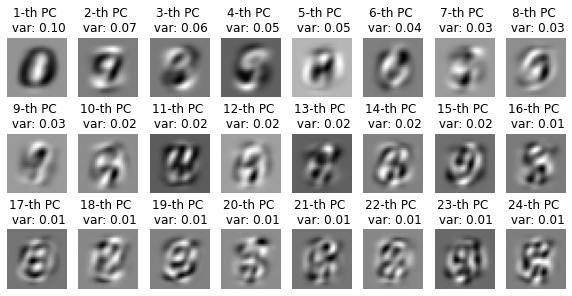

In [12]:
n_row = 3
n_col = 8
n_images = n_row*n_col

plt.figure(figsize=(n_col+2,n_row+2))
for l in range(n_images):
    title = f'{l+1}-th PC \n var: {variance_ratio[l]:.2f}'
    plt_img(v[l,:], title, pos=(n_row,n_col,l+1))

We reduce the data on their first two PC, scatter plot and colour them by class

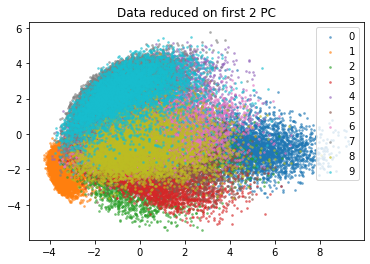

In [13]:
x_hat = x_transformed[:,:2]

for c in range(m):
    plt.scatter(x_hat[y==c,0],x_hat[y==c,1],s=3,alpha=0.5,label=f'{classes[c]}')
plt.title('Data reduced on first 2 PC')
plt.legend()
plt.show()

We now consider only the first PC. This means that we reduce each image to a single number.
We look at the statistical distribution of the first PC broken down by class.

In [14]:
import pandas as pd

x_hat = x_transformed[:,0]

# pandas dataframe 
df = pd.DataFrame(columns=['$\hat{x}$', 'y'])
df.at[:,'$\hat{x}$'] = x_hat
df.at[:,'y'] = classes[y] # original classnames

display(df.head(5)), x_hat[:5], y[:5]

,$\hat{x}$,y
0,0.486010,5
1,3.967523,0
2,-0.203332,4
3,-3.133832,1
4,-1.501000,9


(None,
 array([ 0.48601015,  3.96752304, -0.2033318 , -3.13383152, -1.50099977]),
 array([5, 0, 4, 1, 9], dtype=uint8))

In [15]:
# summarize statistics of first PC by class
df.groupby("y").describe()

$\hat{x}$                                                              \
      count      mean       std       min       25%       50%       75%   
y                                                                         
0    5923.0  3.930579  1.841155 -2.451265  2.693753  3.966723  5.212075   
1    6742.0 -3.301374  0.570232 -4.241803 -3.686713 -3.438026 -3.064771   
2    5958.0  0.368097  1.577817 -3.546043 -0.818196  0.283963  1.425105   
3    6131.0  0.289953  1.436284 -3.568501 -0.725310  0.225638  1.206318   
4    5842.0 -0.233028  1.450917 -3.884125 -1.309701 -0.352650  0.726443   
5    5421.0  0.424589  1.645717 -3.106139 -0.869690  0.377914  1.582404   
6    5918.0  0.672421  1.649346 -3.604370 -0.516567  0.612141  1.819151   
7    6265.0 -1.002003  1.277101 -3.797004 -1.963643 -1.118458 -0.195942   
8    5851.0 -0.013398  1.482804 -3.400997 -1.078149 -0.191972  0.833949   
9    5949.0 -0.598011  1.444663 -3.749670 -1.642196 -0.740268  0.299360   

             
        max  
y            
0  9.267937  
1  1.620124  
2  6.335800  
3  6.278313  
4  5.549536  
5  6.023379  
6  6.696064  
7  4.778061  
8  8.058476  
9  5.817141

In [16]:
from scipy.stats import ks_2samp
ks2samp = np.zeros((m,m))
for c1 in range(m):
    for c2 in range(c1+1,m):
        ks2samp[c1,c2] = ks_2samp(x_hat[y==c1],x_hat[y==c2])[0]

We now measure how different the 1st PC are for given classes (pairwise). For this we use the kolmogorov-smirnov 2-sample test and store the values of the tests statistics.

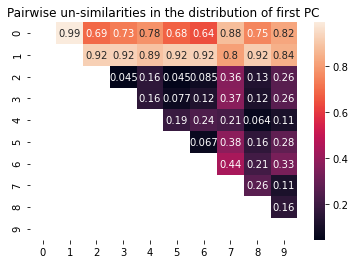

In [18]:
import seaborn as sns
sns.heatmap(ks2samp, annot=True, xticklabels=classes, yticklabels=classes, mask=(ks2samp<=0))
plt.title('Pairwise un-similarities in the distribution of first PC')
plt.show()

## Reduce and Reconstruct

Reduce data on first k PCs. Then reconstruct ist using reduced data.

In [19]:
threshold = 0.9
k = np.where(frac_of_variance>=threshold)[0][0]

# pca on k PC
pca = PCA(n_components=k)
x_hat = pca.fit_transform(x)

# encode test data
x_test_hat = pca.transform(x_test)

x_rec = pca.inverse_transform(x_hat) # reconstruct

print(f'Shape of original data      = {x.shape}')
print(f'Shape of reduced data       = {x_hat.shape}')
print(f'Shape of reconstructed data = {x_rec.shape}')

Shape of original data      = (60000, 784)
Shape of reduced data       = (60000, 86)
Shape of reconstructed data = (60000, 784)


Sample examples and plot original and reconstructed images.

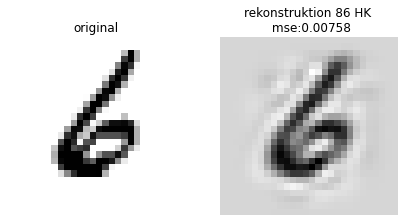

In [21]:
j = randint(n)
plt.figure(figsize=(7,7))
plt_img(x[j], 'original', pos=(1,2,1))
mse = np.mean((x[j]-x_rec[j])**2)
plt_img(x_rec[j], f'rekonstruktion {k} HK \n mse:{mse:.3}', pos=(1,2,2))
plt.show()